In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from global_algorithm_ranking_utils import *
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from N_plotting_utils import *
from problem_classes import *
from N_ranking_utils import *

/opt/conda/envs/Base/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-24 15:24:11.684587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 15:24:13.358462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-24 15:24:13.358676: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [4]:
def gasper_plot(features_preprocessed, features_to_plot,dimension, best_algorithm, query_id,functions_to_plot=100):    

    features_preprocessed=features_preprocessed.dropna()
    
    random_functions=features_preprocessed.query('benchmark=="random"').drop(columns=['benchmark'])
    similarity=cosine_similarity(features_preprocessed.drop(columns=['benchmark']).loc[query_id].values.reshape(1, -1),random_functions)
    similarity=pd.DataFrame(similarity,index=[query_id],columns=random_functions.index).T
    print(best_algorithm.loc[query_id])
    most_similar=similarity.sort_values(by=query_id,ascending=False).head(functions_to_plot).T

    plt.figure(figsize=(10,2))
    #sns.heatmap(most_similar,annot=True,fmt='.2f',)
    sns.barplot(most_similar,color=color_palette[1]).set(xticklabels=[])
    plt.show()
    t=best_algorithm.loc[[query_id]+list(most_similar.columns),['algorithm_name','algorithm_rank']]

    t.index.name='f'
    t=t.reset_index().pivot(index='f', columns='algorithm_name', values='algorithm_rank').loc[[query_id]+list(most_similar.columns)]

    plt.figure(figsize=(6,1.2))
    sns.heatmap(t.T,annot=True,fmt='.0f',cmap='YlGnBu').set(xticklabels=[])
    plt.show()

In [5]:
def drop_correlated_features(df):
    corr_matrix = df.corr( numeric_only =True)
    # Set a threshold for the correlation coefficient
    threshold = 0.9
    to_drop=set()
    # Loop through the columns and drop the ones that have a high correlation with others
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i] # Get the name of the column
                if colname in df.columns:
                    df = df.drop(colname, axis=1)
    return df

In [6]:
def single_performance_alignment_plot(all_features,dimension, best_algorithm, query_id,functions_to_plot=100, plot=True,benchmarks_to_compare_against=None,budget=None,do_discrete_ranking=True):   
    all_results=[]
    if benchmarks_to_compare_against is None:
        benchmarks_to_compare_against=all_benchmarks
    if plot:
        fig, axes=plt.subplots(len(all_features.keys()),1,figsize=(7,2*len(all_features.keys())),sharex=True)
    for features_to_plot_index, features_to_plot in enumerate(all_features.keys()):
        
        features_preprocessed=all_features[features_to_plot]
        
        features_preprocessed_scaled=MinMaxScaler().fit_transform(features_preprocessed.drop(columns=['benchmark']))
        features_preprocessed_scaled=pd.DataFrame(features_preprocessed_scaled, index=features_preprocessed.index, columns=features_preprocessed.drop(columns=['benchmark']).columns)
        features_preprocessed_scaled['benchmark']=features_preprocessed['benchmark']
        features_preprocessed=features_preprocessed_scaled.copy()                           
        features_preprocessed=features_preprocessed.loc[list(set(best_algorithm.index).intersection(set(features_preprocessed.index)))]
        features_preprocessed=features_preprocessed.dropna()
        #features_preprocessed=drop_correlated_features(features_preprocessed)
        random_functions=features_preprocessed.query('benchmark in @benchmarks_to_compare_against').drop(columns=['benchmark'])
        #random_functions=features_preprocessed.drop(columns=['benchmark']).drop(query_id)
        similarity=cosine_similarity(features_preprocessed.drop(columns=['benchmark']).loc[query_id].values.reshape(1, -1),random_functions)
        similarity=pd.DataFrame(similarity,index=[query_id],columns=random_functions.index).T
        
        most_similar=similarity.sort_values(by=query_id,ascending=False).head(functions_to_plot).T
        print(list(most_similar.values))
        t=best_algorithm.loc[[query_id]+list(most_similar.columns),['algorithm_name','algorithm_rank']]
        t.index.name='f'
        t=t.reset_index().pivot(index='f', columns='algorithm_name', values='algorithm_rank').loc[[query_id]+list(most_similar.columns)]
        all_results+=[(features_to_plot, t.T, most_similar.T.min().values[0],most_similar.T.max().values[0])]
        if plot:

            sns.heatmap(t.T,annot=True,fmt='.0f' if do_discrete_ranking else '.3f',cmap='YlGnBu', ax=axes[features_to_plot_index]).set(xticklabels=["query"] + [f'f-{i}' for i in list(range(1,11))])
            axes[features_to_plot_index].set_title(f'Features: {features_to_plot.split("_")[0] if features_to_plot.split("_")[0]!="ela" else "ELA"}, Sample size: {features_to_plot.split("_")[2]}')
            if features_to_plot_index < len(all_features.keys())-1:
                axes[features_to_plot_index].get_xaxis().set_visible(False)
    if plot:
        plt.tight_layout()
        plt.savefig(f'{data_dir}/figures_problem/performance_alignment/{query_id}_vs_{"-".join(benchmarks_to_compare_against)}_dim_{dimension}_budget_{budget}_discrete_ranking_{do_discrete_ranking}_norm.pdf')
        plt.show()
    return all_results

In [7]:
dimension=3
all_features={f'{f}_{sample_count_dimension_factor}d' :get_features(dimension,1000000,feature_dir=f,sample_count_dimension_factor=sample_count_dimension_factor)[1] for f in ['ela_features','transformer_features'] for sample_count_dimension_factor in [50,100]}

functions=[]
all_features['merged_features_50d']=all_features['transformer_features_50d'].drop(columns=['benchmark']).merge(all_features['ela_features_50d'], left_index=True, right_index=True)
all_features['merged_features_100d']=all_features['transformer_features_100d'].drop(columns=['benchmark']).merge(all_features['ela_features_100d'], left_index=True, right_index=True)


20337
20308
20273
20269


1 10
[array([0.98871652, 0.98748563, 0.98487209, 0.98481372, 0.98433628,
       0.98186348, 0.98033502, 0.97779395, 0.97653195, 0.97631826])]
[array([0.99473795, 0.99426383, 0.99395624, 0.99342983, 0.99221003,
       0.98952515, 0.98816317, 0.98776323, 0.98766254, 0.98449366])]
[array([0.99058411, 0.99058411, 0.99058411, 0.9904658 , 0.98969018,
       0.98938351, 0.9892768 , 0.98919193, 0.98870812, 0.98587422])]
[array([0.99099163, 0.98972328, 0.9888044 , 0.9888044 , 0.9888044 ,
       0.98784066, 0.98534589, 0.98521522, 0.98472611, 0.98438869])]
[array([0.98800317, 0.98611661, 0.9838621 , 0.98309004, 0.98306779,
       0.98277828, 0.97708048, 0.9752167 , 0.97458696, 0.97414799])]
[array([0.99160407, 0.98848787, 0.98832061, 0.98637004, 0.98609654,
       0.98578215, 0.98360535, 0.98182912, 0.98169671, 0.98151534])]


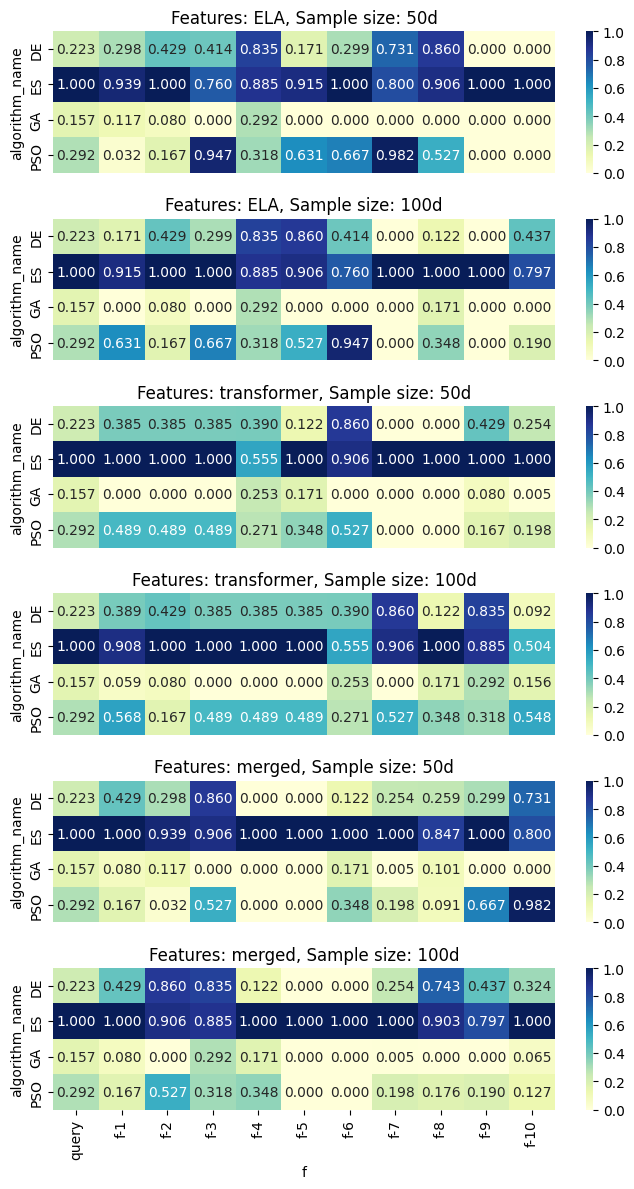

1 30
[array([0.98871652, 0.98748563, 0.98487209, 0.98481372, 0.98433628,
       0.98186348, 0.98033502, 0.97779395, 0.97522109, 0.97419657])]
[array([0.99473795, 0.99426383, 0.99395624, 0.99342983, 0.99221003,
       0.98952515, 0.98776323, 0.98449366, 0.98446557, 0.98365662])]
[array([0.99058411, 0.99058411, 0.99058411, 0.9904658 , 0.98969018,
       0.98938351, 0.98870812, 0.98587422, 0.98512077, 0.98439248])]
[array([0.99099163, 0.98972328, 0.9888044 , 0.9888044 , 0.9888044 ,
       0.98784066, 0.98534589, 0.98521522, 0.98472611, 0.98438869])]
[array([0.98800317, 0.98611661, 0.9838621 , 0.98277828, 0.97708048,
       0.9752167 , 0.97458696, 0.97414799, 0.97376574, 0.97327758])]
[array([0.99160407, 0.98848787, 0.98832061, 0.98637004, 0.98360535,
       0.98182912, 0.98169671, 0.98151534, 0.98137082, 0.98099886])]


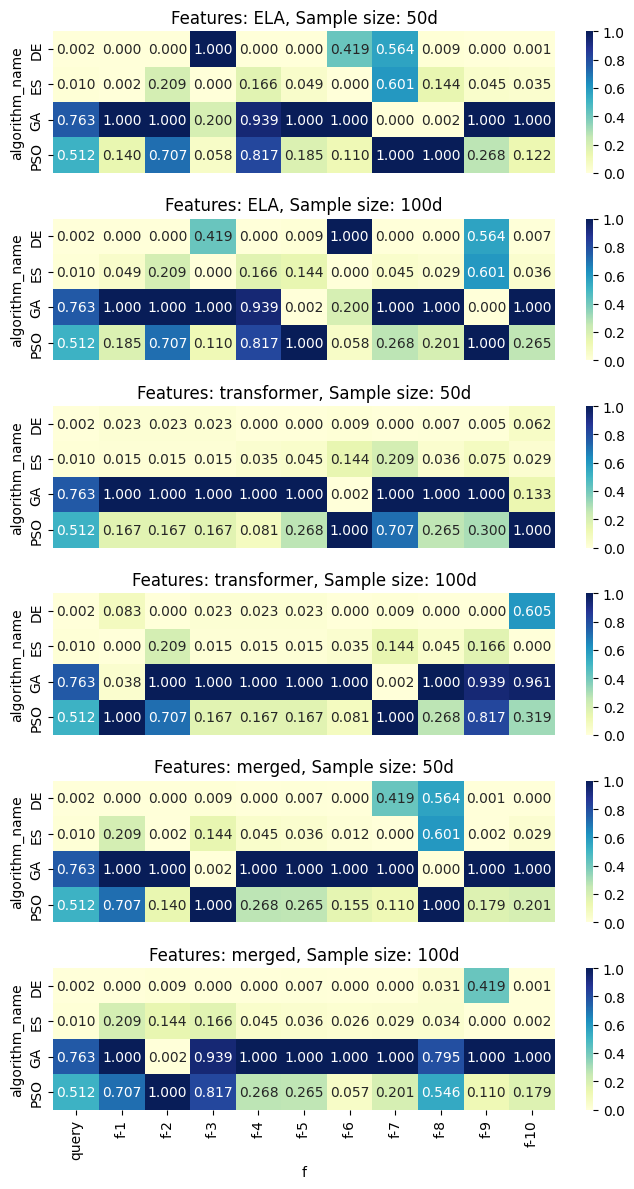

1 50
[array([0.98871652, 0.98748563, 0.98487209, 0.98481372, 0.98433628,
       0.98186348, 0.98033502, 0.97779395, 0.97522109, 0.97419657])]
[array([0.99473795, 0.99426383, 0.99395624, 0.99342983, 0.99221003,
       0.98952515, 0.98776323, 0.98449366, 0.98446557, 0.98365662])]
[array([0.99058411, 0.99058411, 0.99058411, 0.9904658 , 0.98969018,
       0.98938351, 0.98870812, 0.98587422, 0.98512077, 0.98439248])]
[array([0.99099163, 0.98972328, 0.9888044 , 0.9888044 , 0.9888044 ,
       0.98784066, 0.98534589, 0.98521522, 0.98472611, 0.98438869])]
[array([0.98800317, 0.98611661, 0.9838621 , 0.98277828, 0.97708048,
       0.9752167 , 0.97458696, 0.97414799, 0.97376574, 0.97327758])]
[array([0.99160407, 0.98848787, 0.98832061, 0.98637004, 0.98360535,
       0.98182912, 0.98169671, 0.98151534, 0.98137082, 0.98099886])]


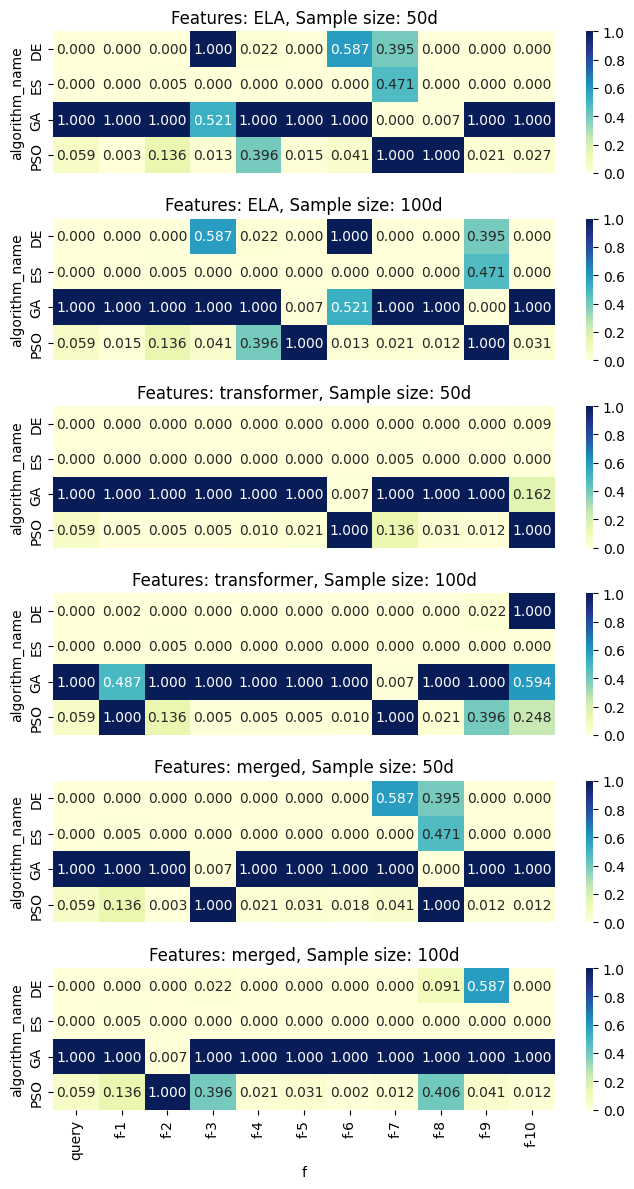

4 10
[array([0.97482569, 0.97434462, 0.97389205, 0.97336911, 0.97312409,
       0.97059977, 0.96659786, 0.96486083, 0.9645668 , 0.96406397])]
[array([0.98187559, 0.97998495, 0.97568044, 0.97550525, 0.9744434 ,
       0.9708578 , 0.96981236, 0.96956246, 0.96781941, 0.96427449])]
[array([0.96854253, 0.96222957, 0.96122847, 0.96094308, 0.96084104,
       0.96084104, 0.96084104, 0.96084104, 0.96084104, 0.96084104])]
[array([0.97415108, 0.96542014, 0.96476156, 0.9647614 , 0.96469031,
       0.96469031, 0.96469031, 0.96469031, 0.96469031, 0.96469031])]
[array([0.96277737, 0.96085656, 0.95446276, 0.95306146, 0.95241474,
       0.95130116, 0.95116677, 0.95080613, 0.95077902, 0.94966669])]
[array([0.96819848, 0.96574018, 0.96093251, 0.96014394, 0.95978616,
       0.95958508, 0.95937582, 0.95917537, 0.95905086, 0.95879103])]


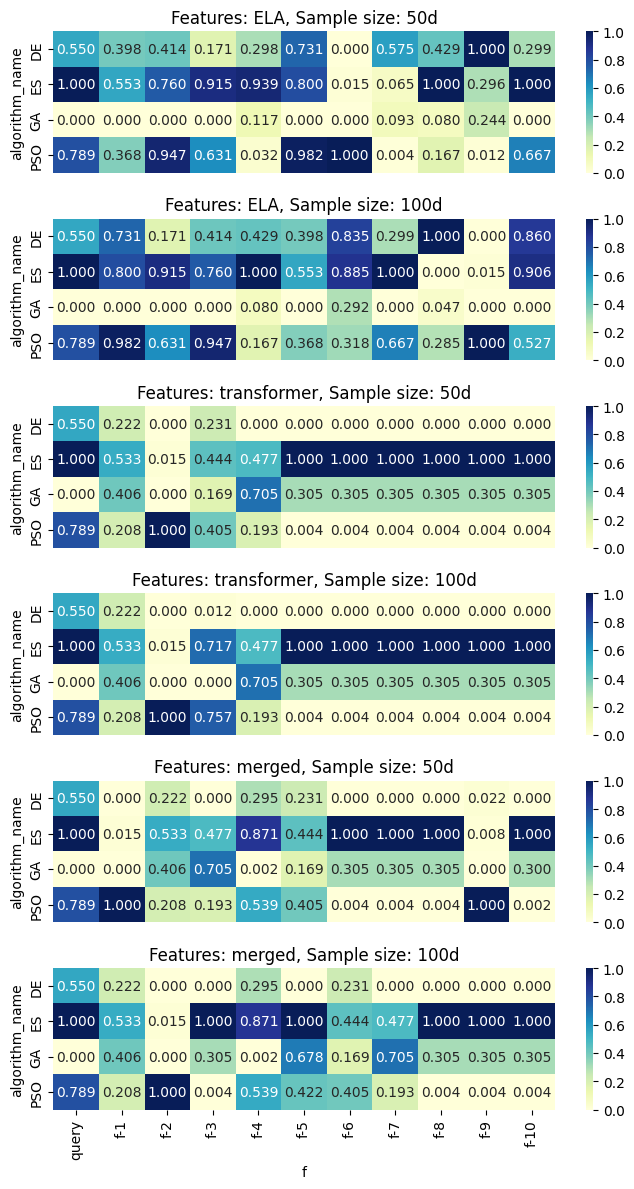

4 30
[array([0.97482569, 0.97434462, 0.97389205, 0.97336911, 0.97312409,
       0.97059977, 0.96659786, 0.96486083, 0.9645668 , 0.96406397])]
[array([0.98187559, 0.97998495, 0.97568044, 0.97550525, 0.9744434 ,
       0.9708578 , 0.96981236, 0.96956246, 0.96781941, 0.96427449])]
[array([0.96854253, 0.96222957, 0.96122847, 0.96094308, 0.96084104,
       0.96084104, 0.96084104, 0.96084104, 0.96084104, 0.96084104])]
[array([0.97415108, 0.96542014, 0.96476156, 0.9647614 , 0.96469031,
       0.96469031, 0.96469031, 0.96469031, 0.96469031, 0.96469031])]
[array([0.96277737, 0.96085656, 0.95446276, 0.95306146, 0.95241474,
       0.95130116, 0.95116677, 0.95080613, 0.95077902, 0.94966669])]
[array([0.96819848, 0.96574018, 0.96093251, 0.96014394, 0.95978616,
       0.95958508, 0.95937582, 0.95917537, 0.95905086, 0.95879103])]


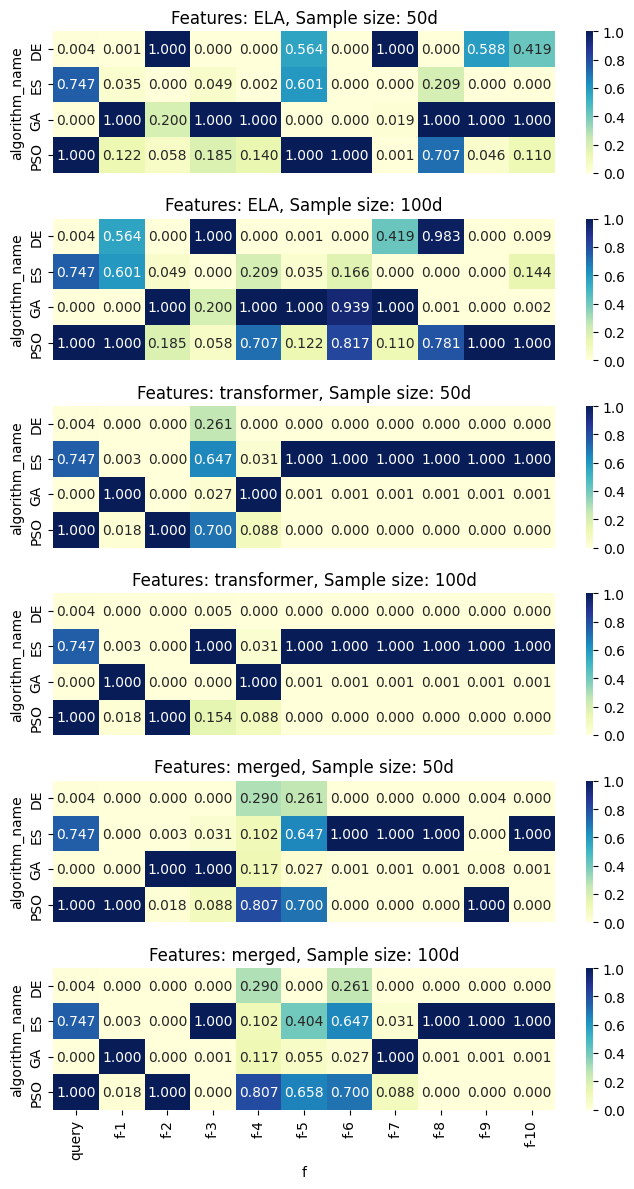

4 50
[array([0.97482569, 0.97434462, 0.97389205, 0.97336911, 0.97312409,
       0.97059977, 0.96659786, 0.96486083, 0.9645668 , 0.96406397])]
[array([0.98187559, 0.97998495, 0.97568044, 0.97550525, 0.9744434 ,
       0.9708578 , 0.96981236, 0.96956246, 0.96781941, 0.96427449])]
[array([0.96854253, 0.96222957, 0.96122847, 0.96094308, 0.96084104,
       0.96084104, 0.96084104, 0.96084104, 0.96084104, 0.96084104])]
[array([0.97415108, 0.96542014, 0.96476156, 0.9647614 , 0.96469031,
       0.96469031, 0.96469031, 0.96469031, 0.96469031, 0.96469031])]
[array([0.96277737, 0.96085656, 0.95446276, 0.95306146, 0.95241474,
       0.95130116, 0.95116677, 0.95080613, 0.95077902, 0.94966669])]
[array([0.96819848, 0.96574018, 0.96093251, 0.96014394, 0.95978616,
       0.95958508, 0.95937582, 0.95917537, 0.95905086, 0.95879103])]


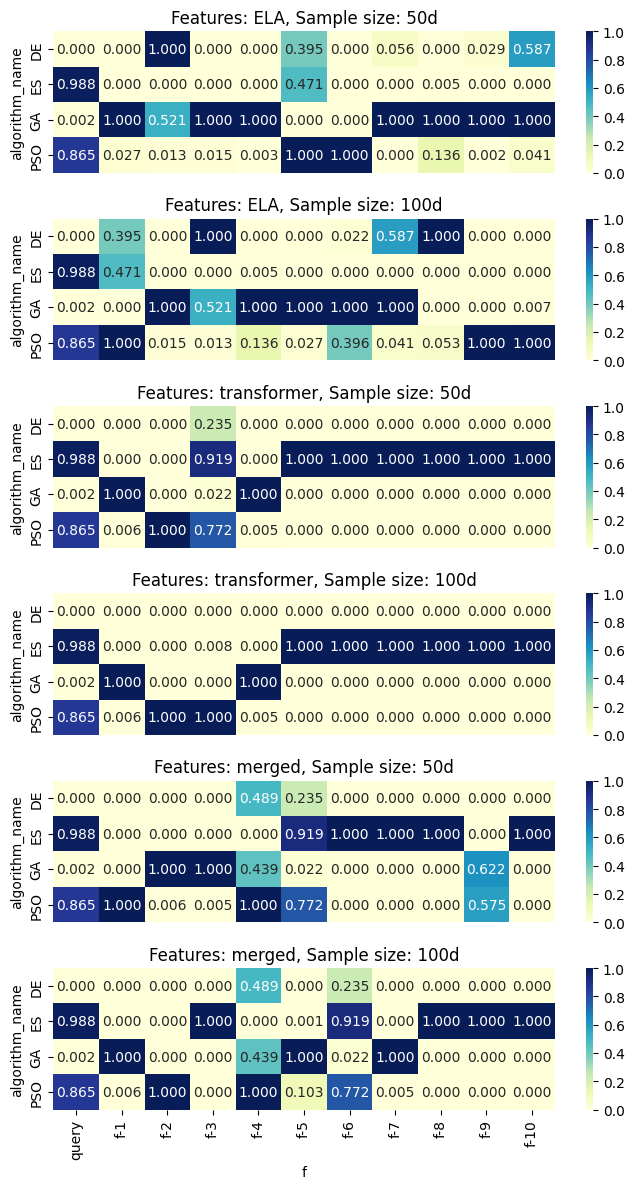

In [13]:

do_discrete_ranking=False
benchmarks_to_compare_against=['random']

functions=[]

algorithm_portfolio='DE-GA-ES-PSO'
best_algorithms_per_budget={}

for budget in [10,30,50]:
    best_algorithm=pd.DataFrame()
    for benchmark in all_benchmarks:
        best_algorithm=pd.concat([best_algorithm, pd.read_csv(f'new_data/algorithm_performance/{benchmark}_{dimension}d_{algorithm_portfolio}_{"ranks" if do_discrete_ranking else "column_normalized_score"}.csv',index_col=0).query('budget==@budget')])
    best_algorithms_per_budget[budget]=best_algorithm

for p in [1,4]:
    functions+=[f'{p}_1']
    for budget in best_algorithms_per_budget.keys():
        print(p, budget)
        r=single_performance_alignment_plot(all_features,dimension, best_algorithms_per_budget[budget], query_id=f'{p}_1',functions_to_plot=10,plot=True,benchmarks_to_compare_against=benchmarks_to_compare_against, budget=budget, do_discrete_ranking=do_discrete_ranking)

        

In [16]:
def aggregated_performance_alignment_plot(all_features,dimension, best_algorithms_per_budget, functions,functions_to_plot=100, benchmarks_to_compare_against=None,do_discrete_ranking=True):   
    all_results=[]
    if benchmarks_to_compare_against is None:
        benchmarks_to_compare_against=all_benchmarks
    for features_to_plot_index, features_to_plot in enumerate(all_features.keys()):
        
        features_preprocessed=all_features[features_to_plot]
        
        features_preprocessed_scaled=MinMaxScaler().fit_transform(features_preprocessed.drop(columns=['benchmark']))
        features_preprocessed_scaled=pd.DataFrame(features_preprocessed_scaled, index=features_preprocessed.index, columns=features_preprocessed.drop(columns=['benchmark']).columns)
        features_preprocessed_scaled['benchmark']=features_preprocessed['benchmark']
        features_preprocessed=features_preprocessed_scaled.copy().dropna()
        features_preprocessed=drop_correlated_features(features_preprocessed)
        random_functions=features_preprocessed.query('benchmark in @benchmarks_to_compare_against').drop(columns=['benchmark'])
        for query_id in functions:
            for budget in best_algorithms_per_budget.keys():
                best_algorithm= best_algorithms_per_budget[budget]
                features_preprocessed_copy=features_preprocessed.copy().loc[list(set(best_algorithm.index).intersection(set(features_preprocessed.index)))]
                
                random_functions_copy=random_functions.copy().loc[list(set(best_algorithm.index).intersection(set(random_functions.index)))]
                similarity=cosine_similarity(features_preprocessed_copy.drop(columns=['benchmark']).loc[query_id].values.reshape(1, -1),random_functions_copy)
                similarity=pd.DataFrame(similarity,index=[query_id],columns=random_functions_copy.index).T

                most_similar=similarity.sort_values(by=query_id,ascending=False).head(functions_to_plot).T
                t=best_algorithm.loc[[query_id]+list(most_similar.columns),['algorithm_name','algorithm_rank']]
                t.index.name='f'
                t=t.reset_index().pivot(index='f', columns='algorithm_name', values='algorithm_rank').loc[[query_id]+list(most_similar.columns)]
               
                query_results = pd.concat([t.iloc[0,:].to_frame().T for i in range(0,t.shape[0]-1)]).reset_index(drop=True)
                query_results.index.name='index'
                value_results = t.iloc[1:t.shape[0],:].reset_index(drop=True)
                value_results.index.name='index'


                #score=np.array([mean_squared_error(first_column, t.iloc[:,i].to_numpy()) for i in range(1, len(t.columns))]).mean()

                score=(calculate_loss(query_results,value_results)+calculate_misrankings_score(query_results,value_results))/2
                t=t.T
                all_results+=[{'f':query_id, 'budget': budget, 'results':t, 'features':features_to_plot, 'min_sim':most_similar.T.min().values[0], 'max_sim':most_similar.T.max().values[0], 'score':score}]

    return all_results

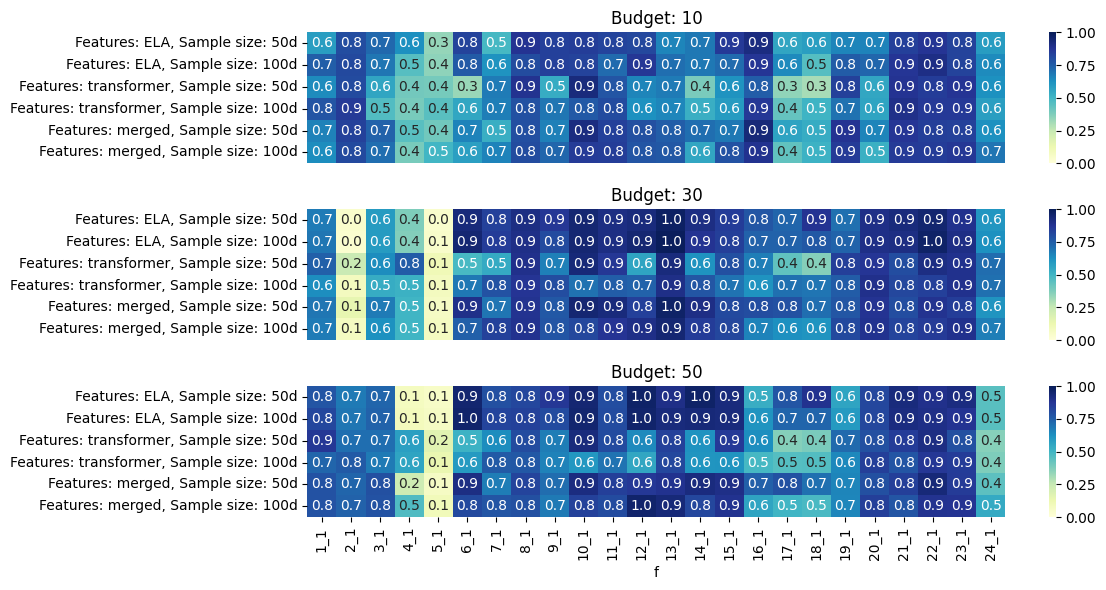

In [17]:
from sklearn.metrics import mean_squared_error


do_discrete_ranking=False
benchmarks_to_compare_against=['m4']
sample_count_dimension_factors=[50,100]

functions=[f'{p}_1' for p in range(1,25)]

algorithm_portfolio='DE-GA-ES-PSO'
best_algorithms_per_budget={}


for budget in [10,30,50]:
    best_algorithm=pd.DataFrame()
    for benchmark in all_benchmarks:
        best_algorithm=pd.concat([best_algorithm, pd.read_csv(f'new_data/algorithm_performance/{benchmark}_{dimension}d_{algorithm_portfolio}_{"ranks" if do_discrete_ranking else "column_normalized_score"}.csv',index_col=0).query('budget==@budget')])
    best_algorithms_per_budget[budget]=best_algorithm

all_results=aggregated_performance_alignment_plot(all_features,dimension, best_algorithms_per_budget, functions,functions_to_plot=10,benchmarks_to_compare_against=benchmarks_to_compare_against)

results_aggregated_df=pd.DataFrame(all_results)

all_budgets=results_aggregated_df['budget'].drop_duplicates().values
fig,axes=plt.subplots(len(all_budgets),1,sharex=True,sharey=True, figsize=(12,6))

for budget_index, budget in enumerate(all_budgets):
    t=results_aggregated_df.query('budget==@budget').drop(columns=['budget'])

    t= t.pivot(index='f',columns='features',values='score').T

    t=t.loc[all_features.keys(), functions]
    t.index=[f'Features: {features.split("_")[0] if features.split("_")[0]!="ela" else "ELA"}, Sample size: {features.split("_")[2]}' for features in t.index]
    #t.to_csv(f'{data_dir}/figures_problem/performance_alignment/data/MSE1_top_10_most_similar_bbob_vs_{"-".join(benchmarks_to_compare_against)}_budget_{budget}_dim_{dimension}_discrete_ranking_{do_discrete_ranking}_norm.csv')
    sns.heatmap(t,annot=True,fmt='.1f',cmap='YlGnBu', ax=axes[budget_index],vmin=0,vmax=2 if do_discrete_ranking else 1)
    axes[budget_index].set_title(f'Budget: {budget}')
    if budget_index==len(all_budgets)-1:
        axes[budget_index].set_xticklabels(axes[budget_index].get_xticklabels(), rotation=90)
    else:
        axes[budget_index].set_xticklabels([])
        x_axis = axes[budget_index].axes.get_xaxis()
        x_axis.set_visible(False)
plt.tight_layout()
plt.margins(x=0)
plt.savefig(f'{data_dir}/figures_problem/performance_alignment/loss_top_10_most_similar_bbob_vs_{"-".join(benchmarks_to_compare_against)}_dim_{dimension}_discrete_ranking_{do_discrete_ranking}_norm.pdf',bbox_inches='tight')
plt.show()      
            

In [ ]:
dimension=3
do_discrete_ranking=False
benchmarks_to_compare_against=['affine']
sample_count_dimension_factors=[50,100]
all_features={f'{f}_{sample_count_dimension_factor}d' :get_features(dimension,1000000,feature_dir=f,sample_count_dimension_factor=sample_count_dimension_factor)[1] for f in ['ela_features','transformer_features'] for sample_count_dimension_factor in sample_count_dimension_factors}

functions=[]
for sf in sample_count_dimension_factors:
    all_features[f'merged_features_{sf}d']=all_features[f'transformer_features_{sf}d'].drop(columns=['benchmark']).merge(all_features[f'ela_features_{sf}d'], left_index=True, right_index=True)

algorithm_portfolio='DE-GA-ES-PSO'
best_algorithms_per_budget={}

all_results=[]
for budget in [10,30,50]:
    best_algorithm=pd.DataFrame()
    for benchmark in all_benchmarks:
        best_algorithm=pd.concat([best_algorithm, pd.read_csv(f'new_data/algorithm_performance/{benchmark}_{dimension}d_{algorithm_portfolio}_{"ranks" if do_discrete_ranking else "column_normalized_score"}.csv',index_col=0).query('budget==@budget')])
    best_algorithms_per_budget[budget]=best_algorithm

for p in range(1,25):
    functions+=[f'{p}_1']
    for budget in best_algorithms_per_budget.keys():
        print(p, budget)
        r=gasper_plot2(dimension, best_algorithms_per_budget[budget], query_id=f'{p}_1',functions_to_plot=10,plot=False,benchmarks_to_compare_against=benchmarks_to_compare_against)
        all_results+=[{'f':f'{p}_1','budget':budget,'results':r}]

        
results_aggregated=[]
for r in all_results:
    f=r['f']
    budget=r['budget']
    for features,res in r['results']:

        t=list(res.iloc[:,0].values)
        scores=abs(res.sub(t, axis='index')).mean(axis=1)
        results_aggregated+=[(f,budget,features , scores.mean())]
        
results_aggregated_df=pd.DataFrame(results_aggregated, columns=['f','budget','features','score'])

all_budgets=results_aggregated_df['budget'].drop_duplicates().values
fig,axes=plt.subplots(len(all_budgets),1,sharex=True,sharey=True, figsize=(14,len(sample_count_dimension_factors)*4))

for budget_index, budget in enumerate(all_budgets):
    t=results_aggregated_df.query('budget==@budget').drop(columns=['budget'])

    t= t.pivot(index='f',columns='features',values='score').T
    t=t.loc[all_features.keys(), functions]
    t.index=[f'Features: {features.split("_")[0]}, Sample size: {features.split("_")[2]}' for features in t.index]
    sns.heatmap(t,annot=True,fmt='.1f',cmap='YlGnBu', ax=axes[budget_index],vmin=0,vmax=2 if do_discrete_ranking else 1)
    axes[budget_index].set_title(f'Budget: {budget}')
plt.tight_layout()
plt.margins(x=0)
plt.savefig(f'{data_dir}/figures_problem/performance_alignment/top_10_most_similar_bbob_vs_{"-".join(benchmarks_to_compare_against)}_dim_{dimension}_discrete_ranking_{do_discrete_ranking}_norm.pdf',bbox_inches='tight')
plt.show()

In [ ]:
def get_instance_similarity(features_preprocessed):
    to_plot=features_preprocessed.drop(columns=['benchmark'])
    features_preprocessed_scaled=MinMaxScaler().fit_transform(to_plot)
    features_preprocessed_scaled=pd.DataFrame(features_preprocessed_scaled, columns=to_plot.columns, index=to_plot.index)
    features_preprocessed_scaled['benchmark']=features_preprocessed['benchmark']
    s=cosine_similarity(features_preprocessed_scaled.drop(columns=['benchmark']),features_preprocessed_scaled.drop(columns=['benchmark']))
    s=pd.DataFrame(s,index=features_preprocessed_scaled.index,columns=features_preprocessed_scaled.index)
    s['benchmark']=features_preprocessed_scaled['benchmark']
    return s

In [ ]:
dimension=3
algorithm_portfolio='DE-GA-ES-PSO'
best_algorithms_per_budget={}
do_discrete_ranking=False
for budget in [10,30,50]:
    best_algorithm=pd.DataFrame()
    for benchmark in all_benchmarks:
        best_algorithm=pd.concat([best_algorithm, pd.read_csv(f'new_data/algorithm_performance/{benchmark}_{dimension}d_{algorithm_portfolio}_{"ranks" if do_discrete_ranking else "column_normalized_score"}.csv',index_col=0).query('budget==@budget')])
    best_algorithms_per_budget[budget]=best_algorithm.reset_index().pivot('f',['algorithm_name'],'algorithm_rank')

In [ ]:
best_algorithms_per_budget[budget]

In [ ]:
dimension=3
all_features={f'{f}_{sample_count_dimension_factor}d' :get_features(dimension,10000,feature_dir=f,sample_count_dimension_factor=sample_count_dimension_factor)[1] for f in ['ela_features','transformer_features'] for sample_count_dimension_factor in [50]}
all_features['merged_features_50d']=all_features['transformer_features_50d'].drop(columns=['benchmark']).merge(all_features['ela_features_50d'], left_index=True, right_index=True)

In [ ]:
features_to_plot='transformer_features_50d'
budget=50
to_plot=[]
for benchmark1 in all_benchmarks:
    for benchmark2 in all_benchmarks:
        benchmark1_instances=list(set.intersection(*[set(all_features[f].query('benchmark==@benchmark1').index) for f in all_features.keys()]).intersection(best_algorithms_per_budget[budget].index))[:20]
        benchmark2_instances=list(set.intersection(*[set(all_features[f].query('benchmark==@benchmark1').index) for f in all_features.keys()]).intersection(best_algorithms_per_budget[budget].index))[:20]
        
        for features_to_plot in all_features.keys():
            print(features_to_plot)
            f=all_features[features_to_plot].loc[benchmark1_instances+benchmark2_instances]
            instance_sim=get_instance_similarity(f)

            for i in benchmark1_instances:
                for j in benchmark2_instances:
                    if i!=j:

                        query_results = best_algorithms_per_budget[budget].loc[i].to_frame().T.reset_index(drop=True)
                        query_results.index.name='index'
                        value_results = best_algorithms_per_budget[budget].loc[j].to_frame().T.reset_index(drop=True)
                        value_results.index.name='index'
                        score=calculate_first_ranked_ranking_score(query_results,value_results)

                        to_plot+=[(instance_sim.loc[i,j], score,benchmark1, benchmark2,i,j,features_to_plot)]


In [ ]:
to_plot_df=pd.DataFrame(to_plot, columns=['feature similarity','performance_sim','benchmark1','benchmark2', 'f1','f2','features'])

In [ ]:
to_plot_df['features'].drop_duplicates()

In [ ]:
g = sns.FacetGrid(to_plot_df.drop(['f1','f2'],axis=1), col="benchmark1",  row="benchmark2", hue='features')
g.map_dataframe(sns.scatterplot, 'feature similarity','performance_sim')

In [ ]:
        sim=pd.DataFrame(to_plot, columns=['feature similarity','performance_sim','benchmark1','benchmark2'])
        print(benchmark1, benchmark2)
        plt.figure()
        sns.scatterplot(sim,x='feature similarity',y='performance_sim')
        plt.show()